In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directories to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

In [2]:
# Setting gpu
torch.cuda.empty_cache()
device = torch.device("cuda")

In [3]:
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size)

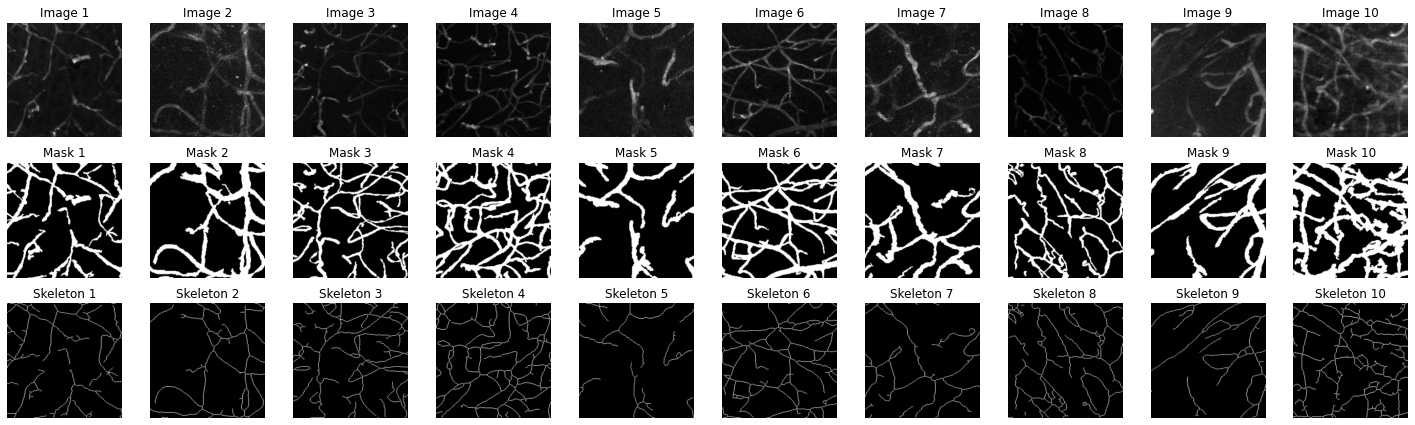

In [4]:
def show_images(data_loader, num_sets=10):
    fig, axs = plt.subplots(3, num_sets, figsize=(20, 6)) # 3 rows for images, masks, and skeletons, and num_sets columns

    # Initialize a counter for the number of sets displayed
    num_displayed = 0

    for images, masks, skeletons in data_loader:
        for i in range(images.size(0)):
            if num_displayed >= num_sets:
                break

            # Plotting image
            axs[0, num_displayed].imshow(images[i].permute(1, 2, 0), cmap='gray') # Rearrange dimensions to HWC for display
            axs[0, num_displayed].axis('off')
            axs[0, num_displayed].set_title(f'Image {num_displayed+1}')

            # Plotting mask
            axs[1, num_displayed].imshow(masks[i].squeeze(), cmap='gray') # Assuming mask is single-channel
            axs[1, num_displayed].axis('off')
            axs[1, num_displayed].set_title(f'Mask {num_displayed+1}')

            # Plotting skeleton
            axs[2, num_displayed].imshow(skeletons[i].squeeze(), cmap='gray') # Assuming skeleton is single-channel
            axs[2, num_displayed].axis('off')
            axs[2, num_displayed].set_title(f'Skeleton {num_displayed+1}')

            num_displayed += 1

        if num_displayed >= num_sets:
            break

    plt.tight_layout()
    plt.show()

# Call the function
show_images(train_loader, num_sets=10)

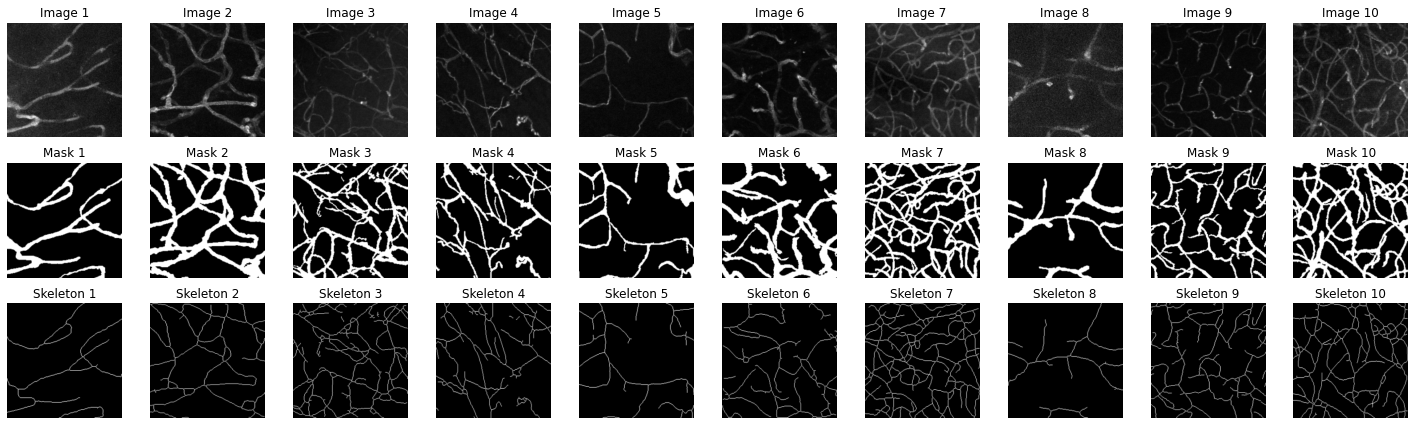

In [5]:
show_images(test_loader, num_sets=10)

In [6]:
len(train_loader)

8

In [7]:
# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def sum_params(model, mode='l2'):
    s = 0
    for param in model.parameters():
        if mode == 'l2':
            s += (param ** 2).sum()
        else:
            s += param.abs().sum()
    return s

In [8]:
def training_loop(num_epochs, regularization_mode, alpha_l1, alpha_l2):
    # Training loop
    for epoch in range(num_epochs):
        model.train() 
        aux_loss = 0.0
        running_aux_loss = 0.0
        running_loss = 0.0
        train_iou = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels, _ = data
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.squeeze(1).long()  # Adjusting the shape of labels for CrossEntropyLoss

            optimizer.zero_grad()

            outputs = model(inputs)
            
            # Calculate the base loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Add L1 regularization if specified
            if regularization_mode == 'l1':
                aux_loss = alpha_l1 * sum_params(model, mode='l1')
                running_aux_loss += aux_loss
                loss += aux_loss
            
            # Add L2 regularization if specified
            if regularization_mode == 'l2':
                aux_loss = alpha_l2 * sum_params(model, mode='l2')
                running_aux_loss += aux_loss
                loss += aux_loss

            _, predicted = torch.max(outputs.data, 1)
            train_iou += iou_metric(labels.float(), predicted.float())
            loss.backward()
            optimizer.step()


        # Calculate and print the average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_iou /= len(train_loader)
        
        train_losses.append(avg_train_loss)
        
        # Calculate and print the average training aux loss
        avg_train_aux_loss = running_aux_loss / len(train_loader)
        train_aux_losses.append(avg_train_aux_loss)

        # Validation
        model.eval()  
        test_loss = 0.0
        total_iou = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels, _ = data
                images, labels = images.cuda(), labels.cuda()
                labels = labels.squeeze(1).long()
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_iou += iou_metric(labels.float(), predicted.float())
        
        avg_test_loss = test_loss / len(test_loader)
        avg_iou = total_iou / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_iou.cpu())
        test_ious.append(avg_iou.cpu())

        scheduler.step(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Aux Loss: {avg_train_aux_loss:.4f} Test Loss: {avg_test_loss:.4f} Train IoU: {train_iou:.4f} Test IoU: {avg_iou:.4f}')

In [9]:
def save_model(model, path, regularization_mode):
  # Saving model
  if regularization_mode == 'none':
    torch.save(model.state_dict(), path)
  else:
    torch.save(model.state_dict(), path)

In [10]:
def plot_avalation(regularization_mode, num_epochs, save_path):
  # 4. Plotting metrics
  plt.figure(figsize=(12, 4))

  # Training and validation loss
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  if regularization_mode != 'none':
    plt.plot([loss.detach().cpu().numpy() for loss in train_aux_losses], label='Training Aux Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training & Validation Loss')
  _ = plt.legend()

  # Test accuracy
  plt.subplot(1, 2, 2)
  plt.plot(test_ious, label='IoU', color='green')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Test IoU')
  _ = plt.legend()
  _ = plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='white')
  _ = plt.tight_layout()
  _ = plt.show()

In [11]:
def model_out(model):
  model.cpu().eval()

  # Select a random batch from the test dataset
  images, masks, _ = next(iter(test_loader))
  if torch.cuda.is_available():
      images, masks = images, masks

  # Get model predictions
  outputs = model(images)
  _, preds = torch.max(outputs, 1)

  # Plot the results
  fig, axs = plt.subplots(len(images), 3, figsize=(12, len(images)*4))
  for idx, (img, mask, pred) in enumerate(zip(images, masks, preds)):
      mask_np = mask.squeeze().cpu().numpy()
      pred_np = pred.squeeze().cpu().numpy()
      
      iou_score = iou_metric(mask_np, pred_np)
      
      
      axs[idx, 0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
      axs[idx, 0].set_title('Original Image')
      
      axs[idx, 1].imshow(mask_np, cmap='gray')
      axs[idx, 1].set_title('Ground Truth Mask')
      
      axs[idx, 2].imshow(pred_np, cmap='gray')
      axs[idx, 2].set_title(f'Predicted Mask (IoU: {iou_score:.4f})')

  for ax in axs.ravel():
      ax.axis('off')

  plt.tight_layout()
  plt.show()

In [12]:
# Placeholders for metrics
train_losses = []
train_aux_losses = []
test_losses = []
test_accuracies = []
test_ious = []

alpha_l1 = 0.00001  # Only used for L1 regularization
alpha_l2 = 0.00001  # Only used for L2 regularization
regularization_mode = 'none' 
num_epochs = 200

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 

weight_decay = 1e-4

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001, 
                       weight_decay=weight_decay)
# Watch scheduler, it reduces LR depend upon on loss, plot LR, acess from optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=10, 
                                                       factor=0.5, 
                                                       verbose=True)

In [13]:
training_loop(num_epochs, regularization_mode, alpha_l1, alpha_l2)

Epoch [1/200] Train Loss: 0.5741 Aux Loss: 0.0000 Test Loss: 0.5159 Train IoU: 0.1502 Test IoU: 0.0153
Epoch [2/200] Train Loss: 0.3791 Aux Loss: 0.0000 Test Loss: 0.5610 Train IoU: 0.3321 Test IoU: 0.0114
Epoch [3/200] Train Loss: 0.2836 Aux Loss: 0.0000 Test Loss: 0.7435 Train IoU: 0.5186 Test IoU: 0.0077
Epoch [4/200] Train Loss: 0.2433 Aux Loss: 0.0000 Test Loss: 0.5511 Train IoU: 0.5876 Test IoU: 0.0551
Epoch [5/200] Train Loss: 0.2295 Aux Loss: 0.0000 Test Loss: 0.3343 Train IoU: 0.6113 Test IoU: 0.2266
Epoch [6/200] Train Loss: 0.2127 Aux Loss: 0.0000 Test Loss: 0.2614 Train IoU: 0.6294 Test IoU: 0.4587
Epoch [7/200] Train Loss: 0.1933 Aux Loss: 0.0000 Test Loss: 0.2364 Train IoU: 0.6639 Test IoU: 0.5187
Epoch [8/200] Train Loss: 0.1884 Aux Loss: 0.0000 Test Loss: 0.2104 Train IoU: 0.6675 Test IoU: 0.5730
Epoch [9/200] Train Loss: 0.1868 Aux Loss: 0.0000 Test Loss: 0.2097 Train IoU: 0.6711 Test IoU: 0.5990
Epoch [10/200] Train Loss: 0.1890 Aux Loss: 0.0000 Test Loss: 0.1758 Trai

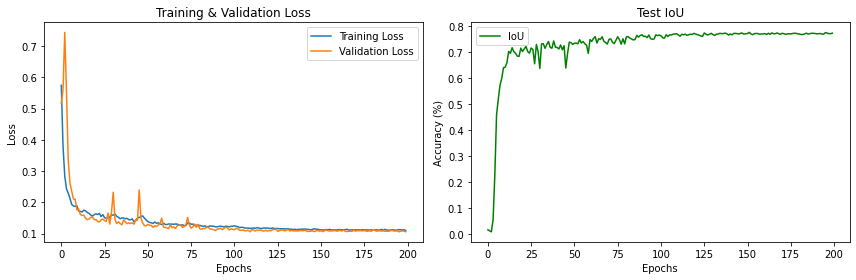

In [14]:
save_model(model, f'../models/vess_map_regularized_{regularization_mode}_{num_epochs}.pth', regularization_mode)
plot_avalation(regularization_mode, num_epochs, f'../models/ModelAnalysis/vess_map_regularized_{regularization_mode}_{num_epochs}.png')

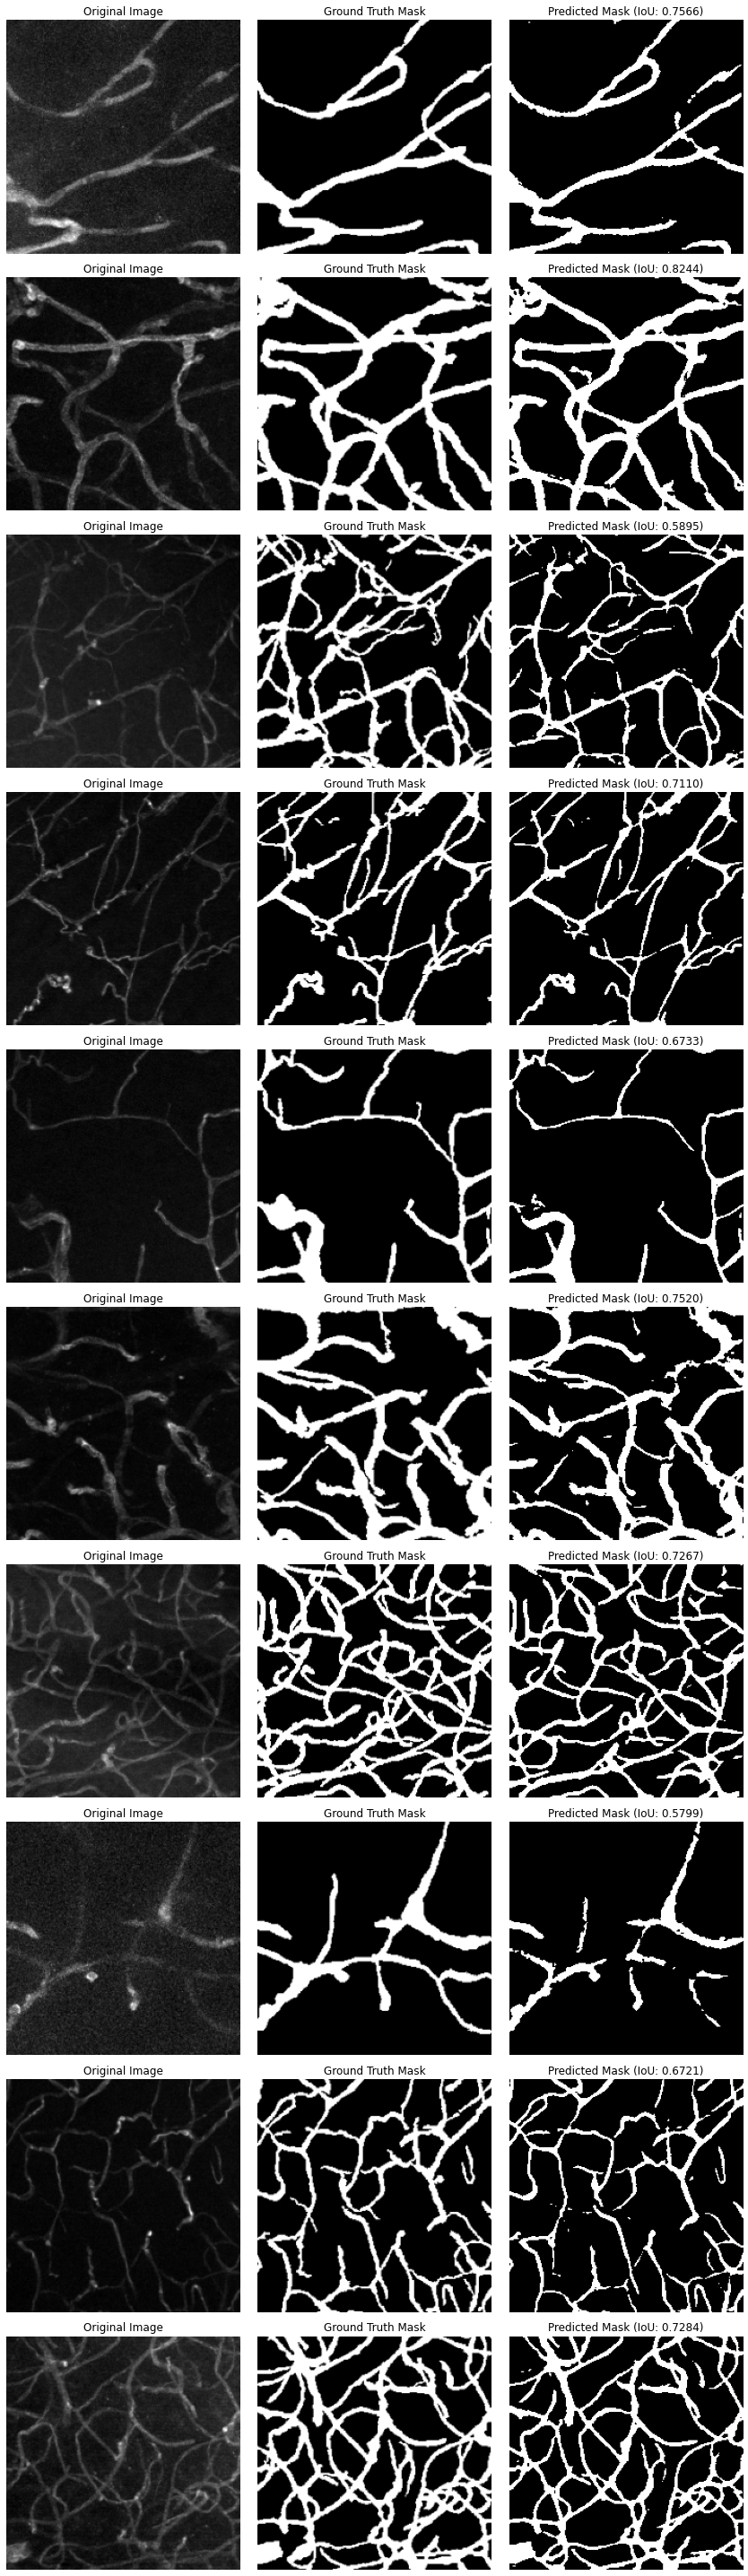

In [15]:
model_out(model)

In [16]:
# Placeholders for metrics
train_losses = []
train_aux_losses = []
test_losses = []
test_accuracies = []
test_ious = []

regularization_mode = 'l1' 
num_epochs = 200

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 

weight_decay = 1e-4

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001, 
                       weight_decay=weight_decay)
# Watch scheduler, it reduces LR depend upon on loss, plot LR, acess from optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=10, 
                                                       factor=0.5, 
                                                       verbose=True)

training_loop(num_epochs, regularization_mode, alpha_l1, alpha_l2)

Epoch [1/200] Train Loss: 0.8864 Aux Loss: 1.9053 Test Loss: 1.2876 Train IoU: 0.1894 Test IoU: 0.1496
Epoch [2/200] Train Loss: 0.5901 Aux Loss: 1.3341 Test Loss: 0.6316 Train IoU: 0.2374 Test IoU: 0.0172
Epoch [3/200] Train Loss: 0.4211 Aux Loss: 1.0273 Test Loss: 0.5282 Train IoU: 0.2700 Test IoU: 0.0041
Epoch [4/200] Train Loss: 0.3566 Aux Loss: 0.8177 Test Loss: 0.5159 Train IoU: 0.3849 Test IoU: 0.0091
Epoch [5/200] Train Loss: 0.3108 Aux Loss: 0.6916 Test Loss: 0.6590 Train IoU: 0.4805 Test IoU: 0.0170
Epoch [6/200] Train Loss: 0.2776 Aux Loss: 0.6004 Test Loss: 0.5802 Train IoU: 0.5273 Test IoU: 0.0952
Epoch [7/200] Train Loss: 0.2535 Aux Loss: 0.5311 Test Loss: 0.4288 Train IoU: 0.5643 Test IoU: 0.2578
Epoch [8/200] Train Loss: 0.2385 Aux Loss: 0.4901 Test Loss: 0.3419 Train IoU: 0.5854 Test IoU: 0.3735
Epoch [9/200] Train Loss: 0.2255 Aux Loss: 0.4452 Test Loss: 0.2154 Train IoU: 0.6200 Test IoU: 0.5699
Epoch [10/200] Train Loss: 0.2235 Aux Loss: 0.4230 Test Loss: 0.2051 Trai

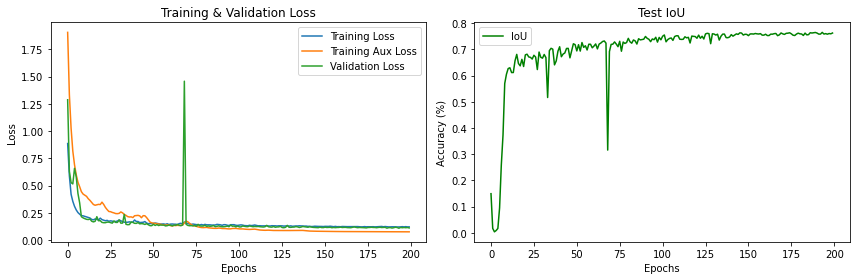

In [17]:
save_model(model, f'../models/vess_map_regularized_{regularization_mode}_{num_epochs}.pth', regularization_mode)
plot_avalation(regularization_mode, num_epochs, f'../models/ModelAnalysis/vess_map_regularized_{regularization_mode}_{num_epochs}.png')

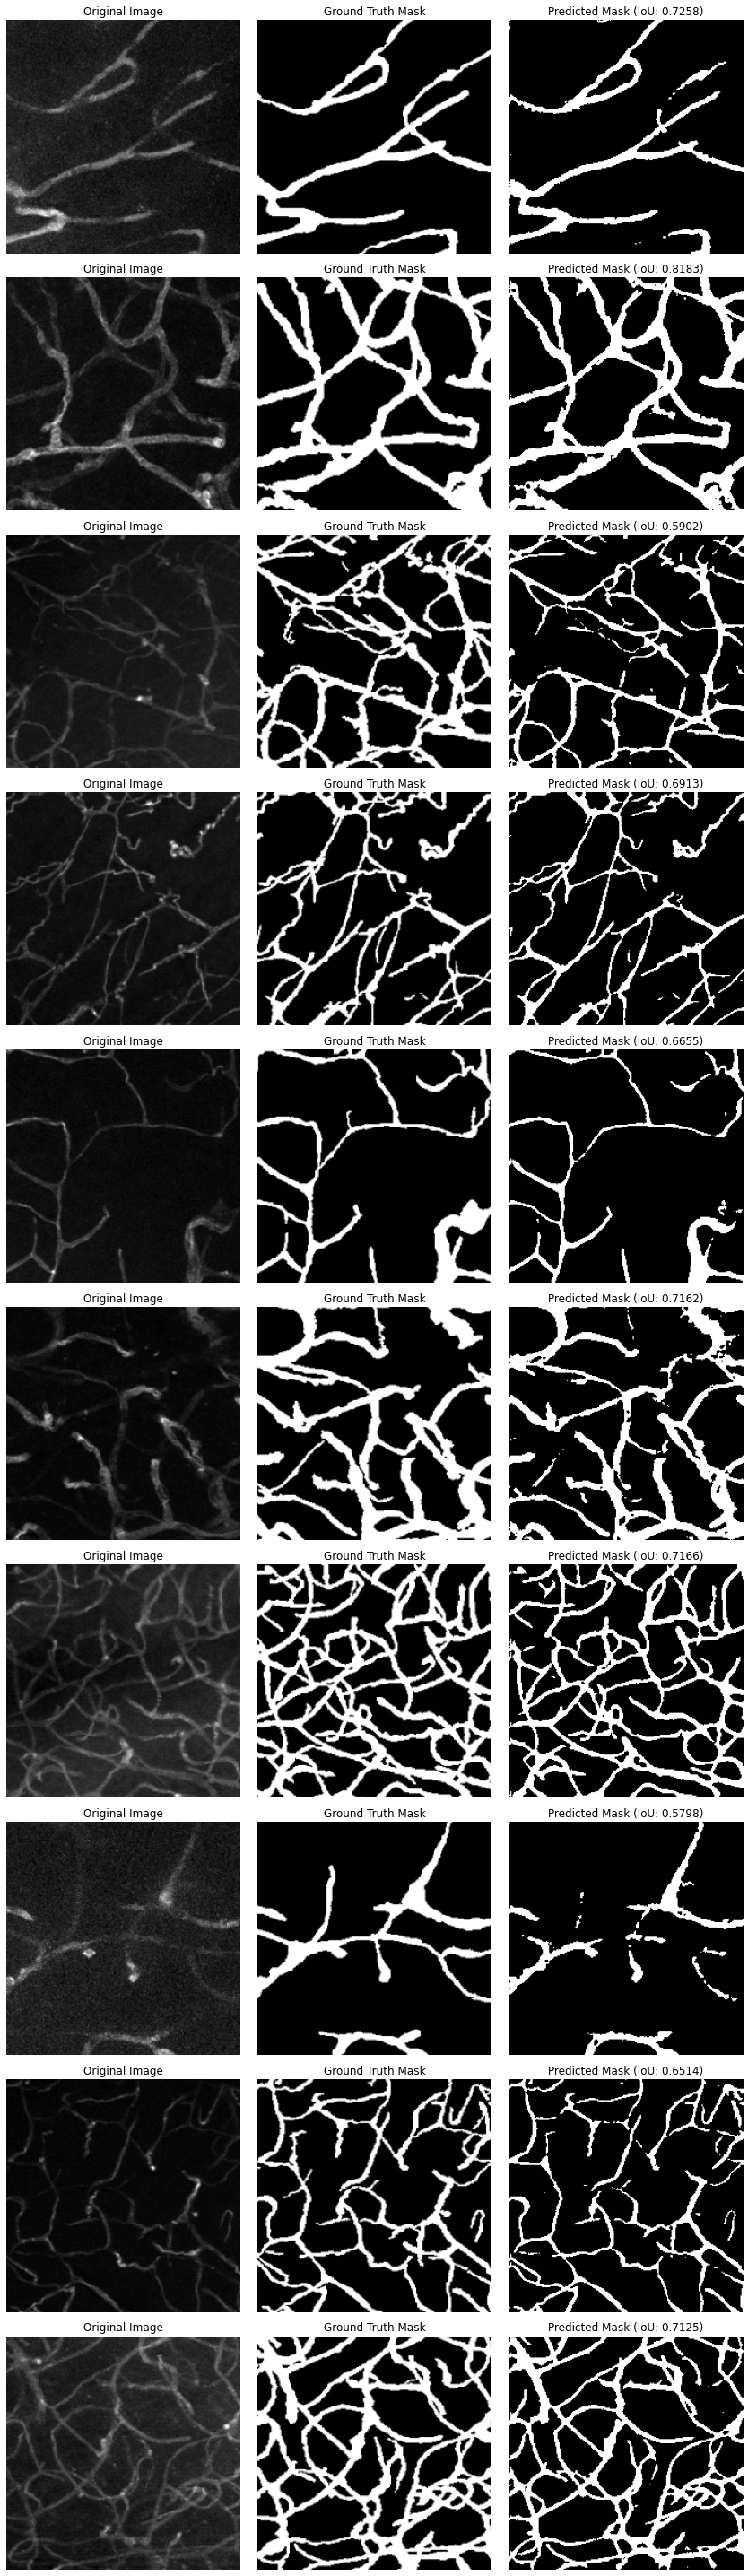

In [18]:
model_out(model)

In [19]:
train_losses = []
train_aux_losses = []
test_losses = []
test_accuracies = []
test_ious = []

regularization_mode = 'l2' 
num_epochs = 200 
alpha_l2 = 0.00099  # Only used for L2 regularization

# Model Initialization
model = CustomResNet(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001, 
                       weight_decay=weight_decay)
# Watch scheduler, it reduces LR depend upon on loss, plot LR, acess from optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=10, 
                                                       factor=0.5, 
                                                       verbose=True)

training_loop(num_epochs, regularization_mode, alpha_l1, alpha_l2)

Epoch [1/200] Train Loss: 0.5972 Aux Loss: 7.4469 Test Loss: 0.5076 Train IoU: 0.1961 Test IoU: 0.0072
Epoch [2/200] Train Loss: 0.3335 Aux Loss: 6.5049 Test Loss: 0.7915 Train IoU: 0.4328 Test IoU: 0.0046
Epoch [3/200] Train Loss: 0.2768 Aux Loss: 6.1726 Test Loss: 0.8971 Train IoU: 0.5426 Test IoU: 0.0034
Epoch [4/200] Train Loss: 0.2639 Aux Loss: 5.9718 Test Loss: 0.6551 Train IoU: 0.5626 Test IoU: 0.0243
Epoch [5/200] Train Loss: 0.2362 Aux Loss: 5.8200 Test Loss: 0.4143 Train IoU: 0.5983 Test IoU: 0.1730
Epoch [6/200] Train Loss: 0.2121 Aux Loss: 5.6730 Test Loss: 0.3843 Train IoU: 0.6382 Test IoU: 0.2655
Epoch [7/200] Train Loss: 0.2004 Aux Loss: 5.5388 Test Loss: 0.2471 Train IoU: 0.6512 Test IoU: 0.4718
Epoch [8/200] Train Loss: 0.1929 Aux Loss: 5.4252 Test Loss: 0.3011 Train IoU: 0.6705 Test IoU: 0.4018
Epoch [9/200] Train Loss: 0.1895 Aux Loss: 5.3091 Test Loss: 0.1921 Train IoU: 0.6682 Test IoU: 0.5882
Epoch [10/200] Train Loss: 0.1879 Aux Loss: 5.2068 Test Loss: 0.1859 Trai

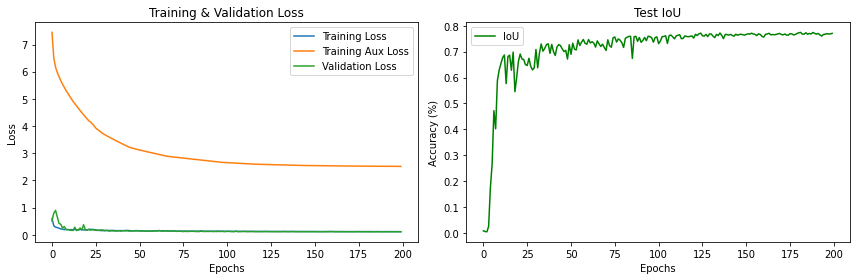

In [20]:
save_model(model, f'../models/vess_map_regularized_{regularization_mode}_{num_epochs}.pth', regularization_mode)
plot_avalation(regularization_mode, num_epochs, f'../models/ModelAnalysis/vess_map_regularized_{regularization_mode}_{num_epochs}.png')

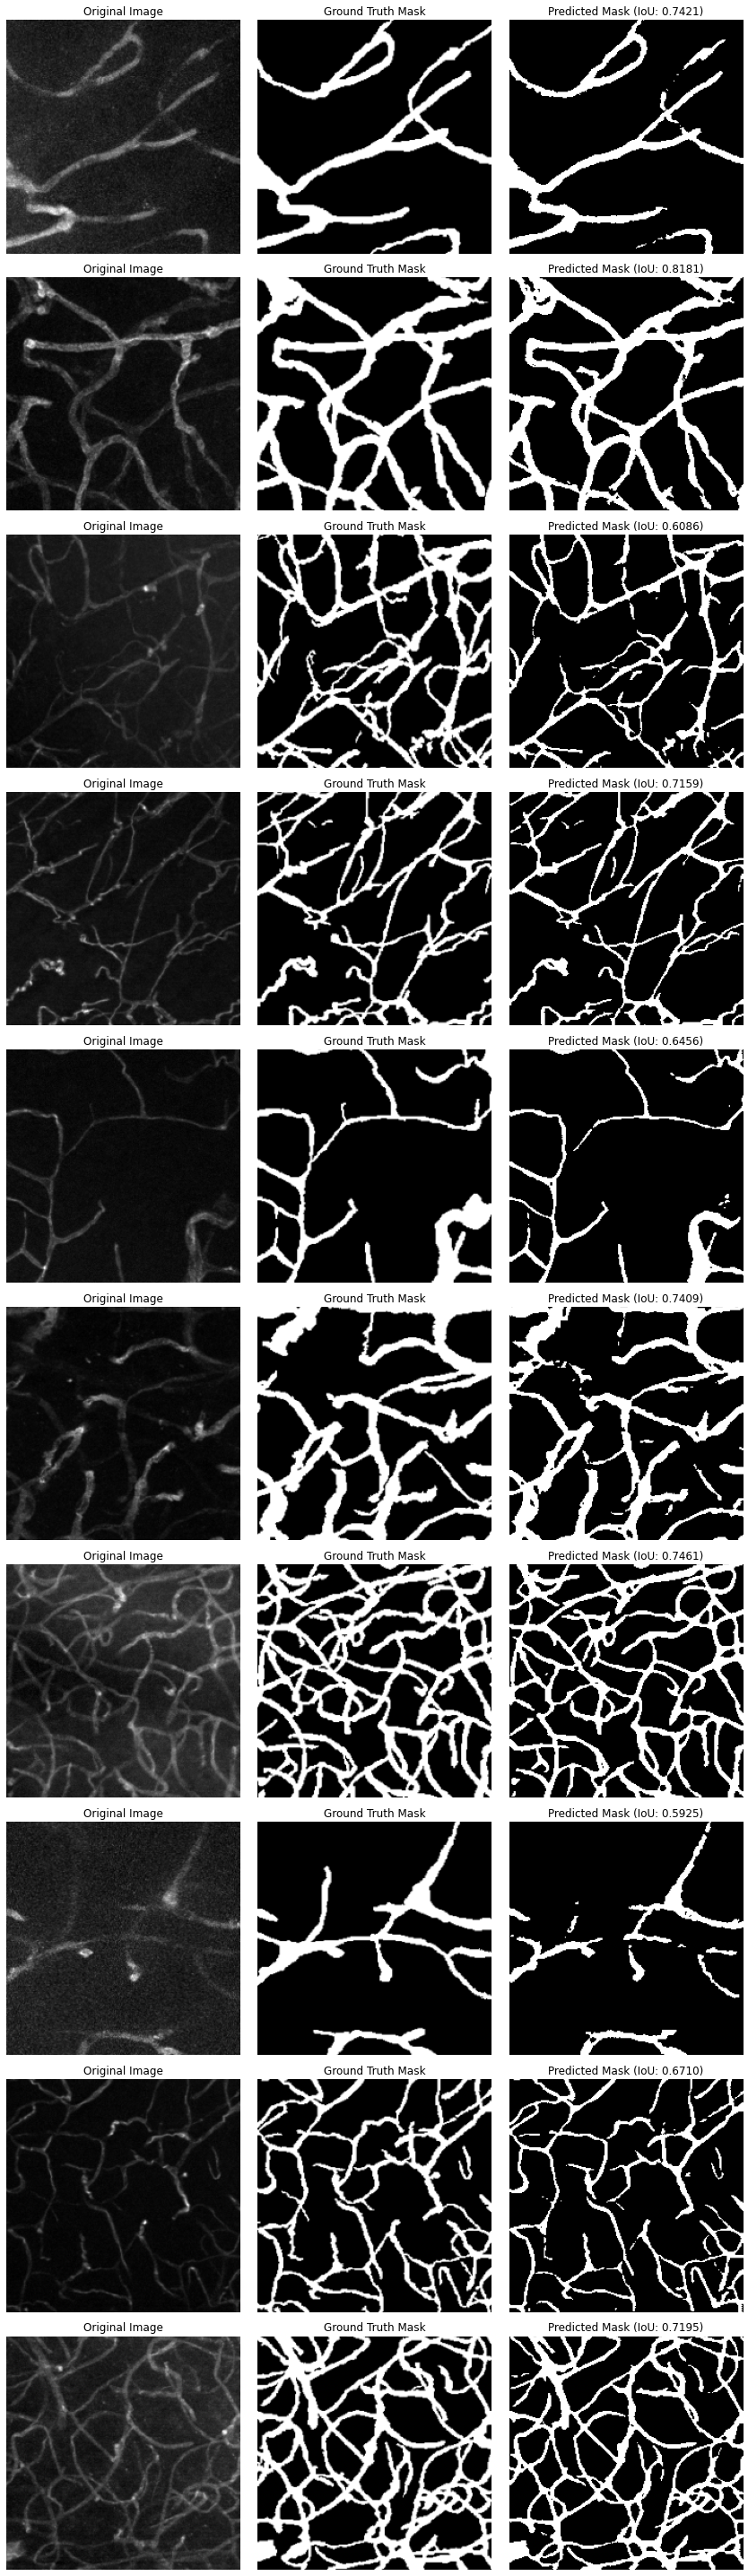

In [21]:
model_out(model)